# Разработка решения, позволяющее оптимизировать управление персоналом, для HR-аналитики компании «Работа с заботой».

## Описание данных

**Задача 1: Предсказание уровня удовлетворённости сотрудника.**  

Для этой задачи заказчик предоставил данные с признаками:
- `id` — уникальный идентификатор сотрудника
- `dept` — отдел, в котором работает сотрудник
- `level` — уровень занимаемой должности
- `workload` — уровень загруженности сотрудника
- `employment_years` — длительность работы в компании (в годах)
- `last_year_promo` — показывает, было ли повышение за последний год
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель
- `salary` — ежемесячная зарплата сотрудника
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак

Предоставлены данные в нескольких таблицах:
- Тренировочная выборка: `train_job_satisfaction_rate.csv`  
- Входные признаки тестовой выборки: `test_features.csv`  
- Целевой признак тестовой выборки: `test_target_job_satisfaction_rate.csv`

**Задача 2: Предсказание увольнения сотрудника из компании.**

Для этой задачи мы можем использовать те же входные признаки, что и в предыдущей задаче.  
Однако целевой признак отличается: это `quit` — увольнение сотрудника из компании.

Предоставлены данные в нескольких таблицах:

- Тренировочная выборка: `train_quit.csv`
- Входные признаки тестовой выборки: `test_features.csv`
- Целевой признак тестовой выборки: `test_target_quit.csv`

**Импорты**

In [1]:
!pip install -U scikit-learn -q
!pip install phik -q
!pip install shap -q
!pip install seaborn==0.13.0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, model_selection, metrics
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif 
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

import phik
import shap

## Задача 1

### Шаг 1. Загрузка данных

In [3]:
try:
    train_job_satisfaction_rate = pd.read_csv('C:/Users/zephy/#Composite_project_2/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('C:/Users/zephy/#Composite_project_2/test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('C:/Users/zephy/#Composite_project_2/test_target_job_satisfaction_rate.csv')

except:
    train_job_satisfaction_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    test_features = pd.read_csv('/datasets/test_features.csv')
    test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

In [4]:
display(train_job_satisfaction_rate.head())

print('Размерность датафрейма train_job_satisfaction_rate:', train_job_satisfaction_rate.shape)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Размерность датафрейма train_job_satisfaction_rate: (4000, 10)


In [5]:
display(test_features.head())

print('Размерность датафрейма test_features:', test_features.shape)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Размерность датафрейма test_features: (2000, 9)


In [6]:
display(test_target_job_satisfaction_rate.head())

print('Размерность датафрейма test_target_job_satisfaction_rate:', test_target_job_satisfaction_rate.shape)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Размерность датафрейма test_target_job_satisfaction_rate: (2000, 2)


Три датафрейма загружены и читаются.

### Шаг 2. Предобработка данных

In [7]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [8]:
train_job_satisfaction_rate.isna().sum()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Обнаруженные пропущенные значения у признаков `dept` и `level` заполним позже в пайплайне.

In [9]:
# Проверка явные дубликаты:

train_job_satisfaction_rate.duplicated().sum()

0

In [10]:
# Перечень численных признаков:

num_list = train_job_satisfaction_rate.drop('id', axis=1).select_dtypes(include=np.number).columns.tolist()
num_list

['employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

In [11]:
for item in num_list:
    print('\n',train_job_satisfaction_rate[item].unique())


 [ 2  1  4  7  9  6  3 10  8  5]

 [1 5 2 3 4]

 [24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800
 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000
 43200 46800 58800 84000 44400 39600 37200 21600 28800 62400 60000 42000
 49200 55200 57600 68400 45600 51600 64800 80400 20400 61200 76800 69600
 16800 36000 63600 81600 66000 74400 67200 70800 73200 75600 79200 94800
 78000 88800 92400 85200 91200 98400 96000 97200]

 [0.58 0.76 0.11 0.37 0.2  0.78 0.56 0.44 0.14 0.47 0.74 0.42 0.32 0.57
 0.16 0.69 0.33 0.64 0.39 0.8  0.79 0.17 0.65 0.18 0.19 0.49 0.63 0.22
 0.23 0.5  0.35 0.3  0.77 0.88 0.59 0.21 0.36 0.85 0.7  0.48 0.6  0.1
 0.27 0.71 0.86 0.54 0.73 0.46 0.31 0.72 0.51 0.61 0.81 0.99 0.15 0.91
 0.68 0.4  0.89 0.67 0.75 0.98 0.26 0.45 0.92 0.82 0.66 0.55 0.38 0.53
 0.84 0.52 0.24 0.62 0.41 0.28 0.09 0.97 0.83 0.25 0.43 0.04 0.13 0.29
 0.95 0.93 0.87 0.08 0.94 0.07 0.34 0.9  0.12 0.06 0.96 0.05 1.   0.03]


In [12]:
# Перечень категориальных признаков:

cat_list = train_job_satisfaction_rate.select_dtypes(exclude=np.number).columns.tolist()
cat_list

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

In [13]:
# Проверка на неявные дубликаты:

for item in cat_list:
    print('\n',train_job_satisfaction_rate[item].unique())


 ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

 ['junior' 'middle' 'sinior' nan]

 ['medium' 'high' 'low']

 ['no' 'yes']

 ['no' 'yes']


In [14]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [15]:
# Проверка явные дубликаты:

test_features.duplicated().sum()

0

In [16]:
# Перечень численных признаков:

num_list = test_features.drop('id', axis=1).select_dtypes(include=np.number).columns.tolist()
num_list

['employment_years', 'supervisor_evaluation', 'salary']

In [17]:
for item in num_list:
    print('\n',test_features[item].unique())


 [ 2  1  5  6  3  9  7  4  8 10]

 [5 4 3 1 2]

 [28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000
 78000 75600 73200 84000 88800 92400]


In [18]:
# Перечень категориальных признаков:

cat_list = test_features.select_dtypes(exclude=np.number).columns.tolist()
cat_list

['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

In [19]:
# Проверка на неявные дубликаты:

for item in test_features.select_dtypes(include=['object']):
    print(test_features[item].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


In [20]:
# Выявленные пропуски в значениях заменяем на NaN:

test_features['dept'] = test_features['dept'].replace(' ', np.nan)
test_features['workload'] = test_features['workload'].replace(' ', np.nan)

In [21]:
# Проверяем:

for item in test_features.select_dtypes(include=['object']):
    print(test_features[item].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' nan]
['no' 'yes']
['no' 'yes']


In [22]:
test_target_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [23]:
test_target_job_satisfaction_rate.duplicated().sum()

0

### Шаг 3. Исследовательский анализ данных

**train_job_satisfaction_rate**

In [24]:
num_list_cont = ['salary', 'job_satisfaction_rate']
num_list_dis = ['employment_years', 'supervisor_evaluation']

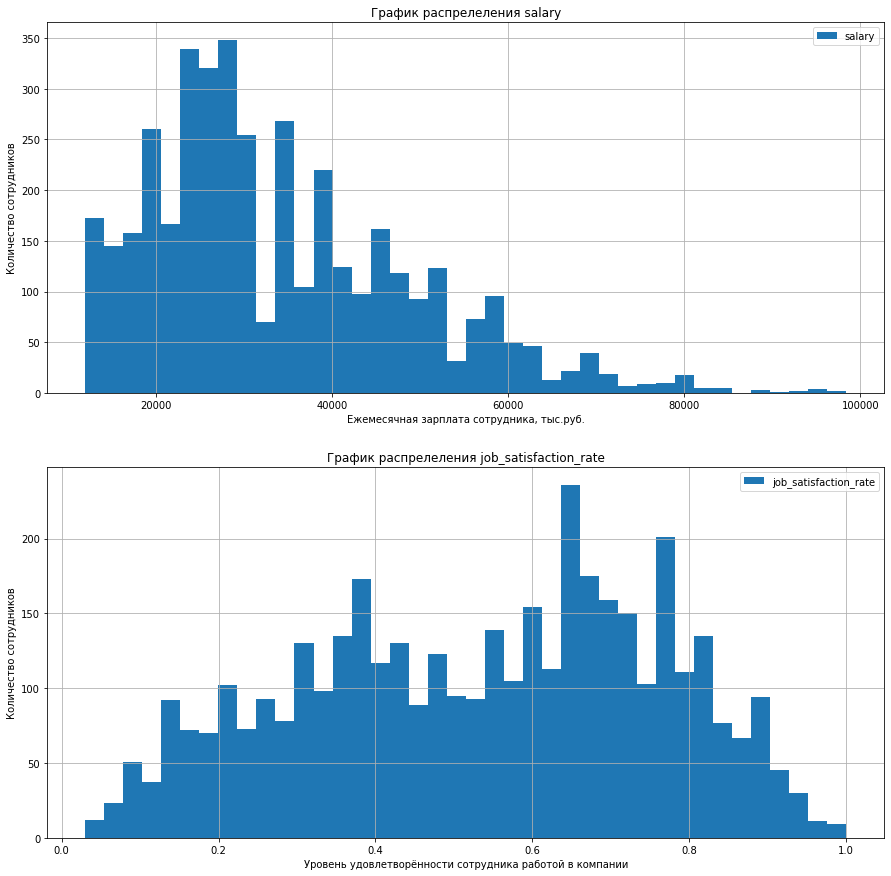

In [25]:
# Распределение значений численных признаков, проверка на выбросы:

xlabel_list_cont = ['Ежемесячная зарплата сотрудника, тыс.руб.',
                    'Уровень удовлетворённости сотрудника работой в компании']
               
fig = plt.figure(figsize=(15,15))

for i, column in enumerate(num_list_cont):
    fig.add_subplot(2, 1, i + 1);
    ax = train_job_satisfaction_rate[column].plot(kind="hist", title=column, bins=40, grid=True);
    ax.set_xlabel(xlabel_list_cont[i])
    ax.set_ylabel('Количество сотрудников')
    ax.set_title(f'График распрелеления {num_list_cont[i]}')
    ax.legend([num_list_cont[i]])
plt.show()

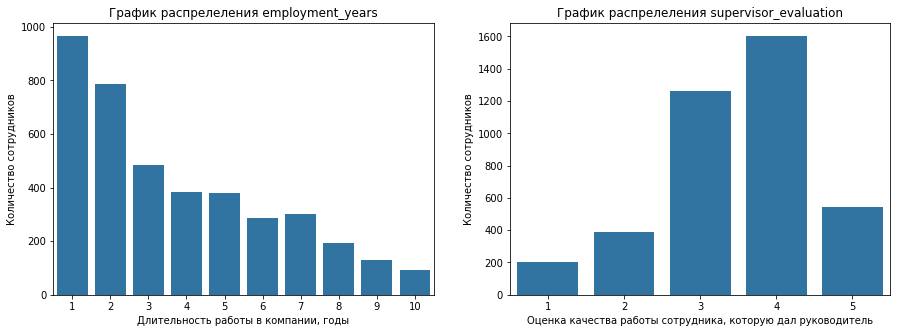

In [26]:
xlabel_list_dis = ['Длительность работы в компании, годы',
                   'Оценка качества работы сотрудника, которую дал руководитель']
               
fig = plt.figure(figsize=(15,5))
for i, col in enumerate(num_list_dis):
    fig.add_subplot(1, 2, i+1)
    ax = sns.countplot(train_job_satisfaction_rate, x=col)
    ax.set_title(f'График распрелеления {num_list_dis[i]}')
    ax.set_xlabel(xlabel_list_dis[i])
    ax.set_ylabel('Количество сотрудников')
plt.show()

In [27]:
# Создадим функцию для визуализации распределения значений числовых признаков типа "Ящик с усами":

def hist_num_boxplot(num_list_bx, x_label_num_list_bx, df1):
    fig  = plt.figure(figsize=(20,20))

    for i, column in enumerate(num_list_bx):
        ax = fig.add_subplot(3, round(len(x_label_num_list_bx)/2), i + 1);
        ax.boxplot([df1[column]]); 
        ax.set_ylabel(x_label_num_list_bx[i], fontsize=10);
        ax.set_title(f'Диаграмма размаха для {num_list_bx[i]}')
    plt.show()

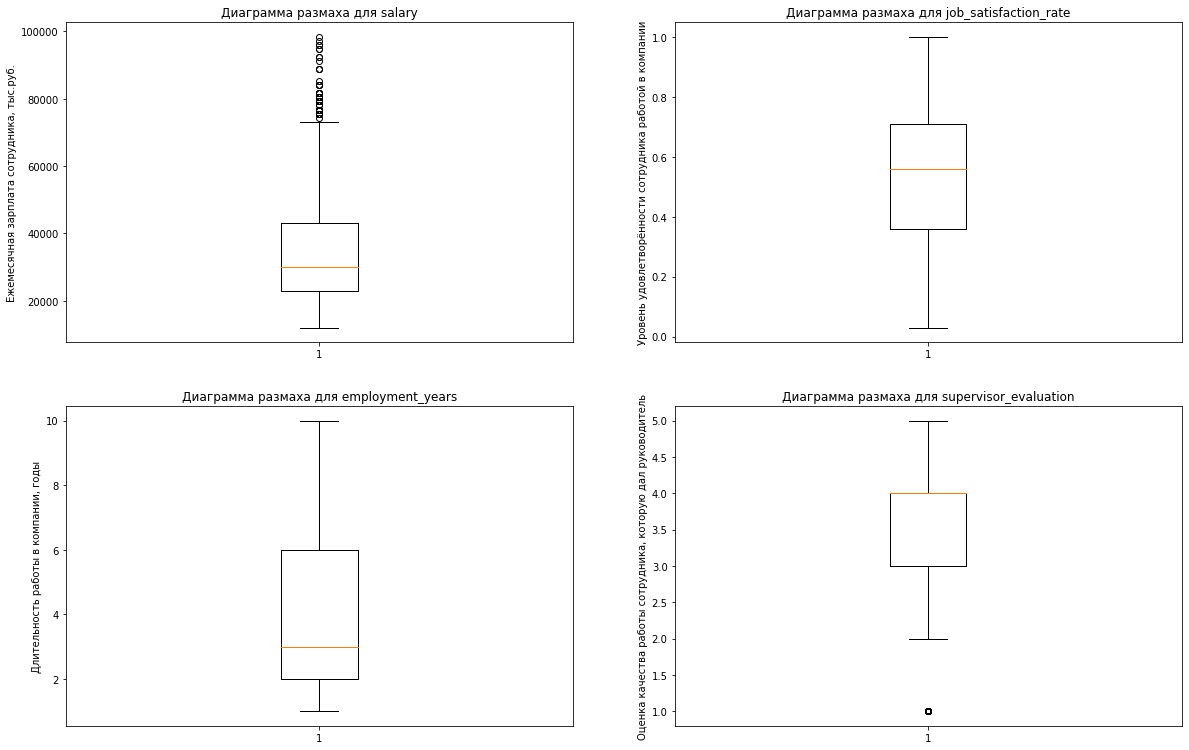

In [28]:
num_list_bx = num_list_cont + num_list_dis
x_label_num_list_bx = xlabel_list_cont + xlabel_list_dis
 
hist_num_boxplot(num_list_bx, x_label_num_list_bx, train_job_satisfaction_rate)

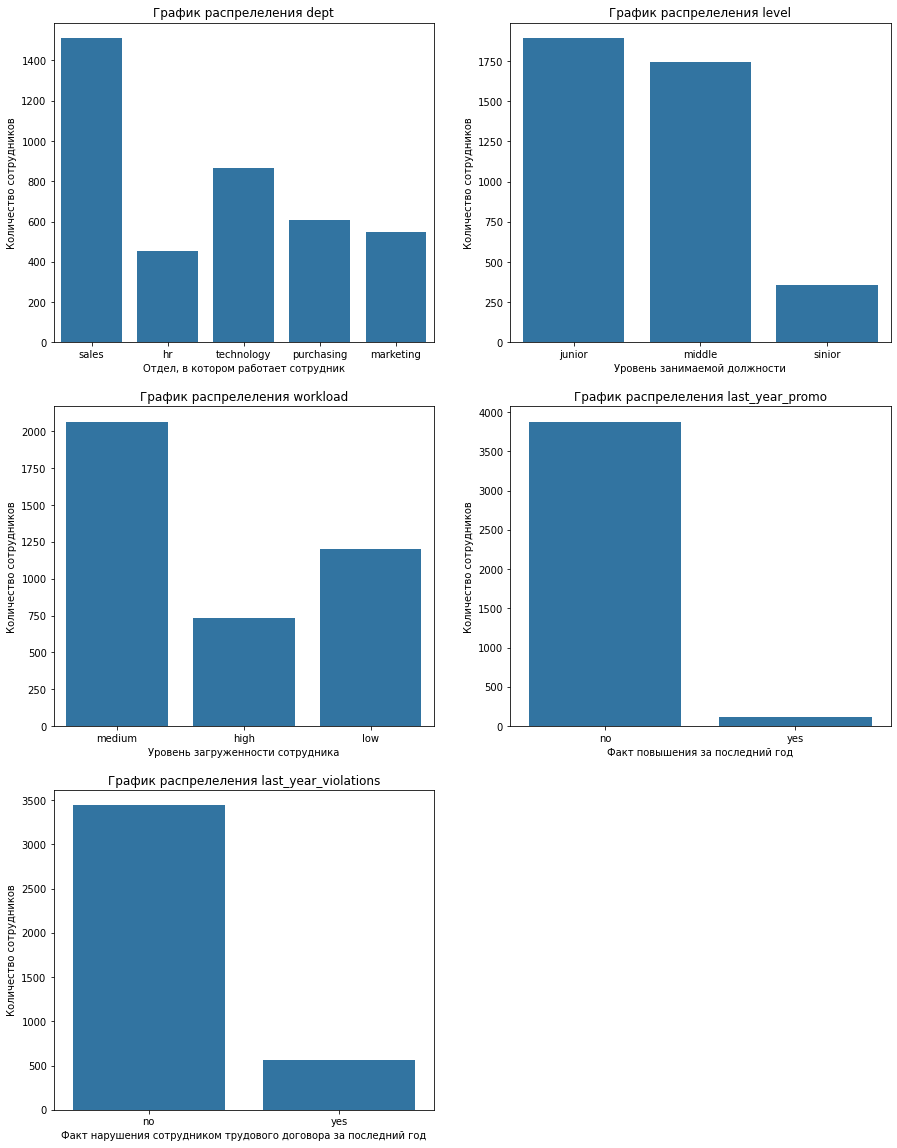

In [29]:
# Распределение значений категориальных признаков:

xlabel_cat_list = ['Отдел, в котором работает сотрудник',
                  'Уровень занимаемой должности',
                  'Уровень загруженности сотрудника',
                  'Факт повышения за последний год',
                  'Факт нарушения сотрудником трудового договора за последний год']

fig = plt.figure(figsize=(15,20))
for i, col in enumerate(cat_list):
    fig.add_subplot(3, 2, i+1)
    ax = sns.countplot(train_job_satisfaction_rate, x=col)
    ax.set_title(f'График распрелеления {cat_list[i]}')
    ax.set_xlabel(xlabel_cat_list[i])
    ax.set_ylabel('Количество сотрудников')
plt.show()

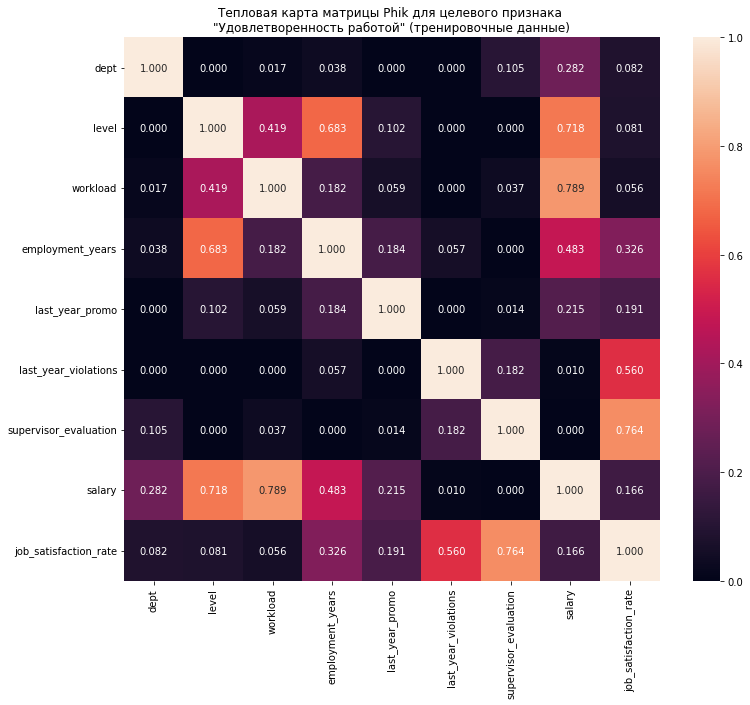

In [30]:
# Построим тепловую карту матрицы Phik для признаков датафрейма:

phik_matrix = phik.phik_matrix(train_job_satisfaction_rate.drop('id', axis=1), interval_cols=['job_satisfaction_rate', 'salary']);
plt.figure(figsize=(12,10));
sns.heatmap(phik_matrix, annot=True, fmt='.3f');
plt.title('Тепловая карта матрицы Phik для целевого признака \n"Удовлетворенность работой" (тренировочные данные)', fontsize=12);

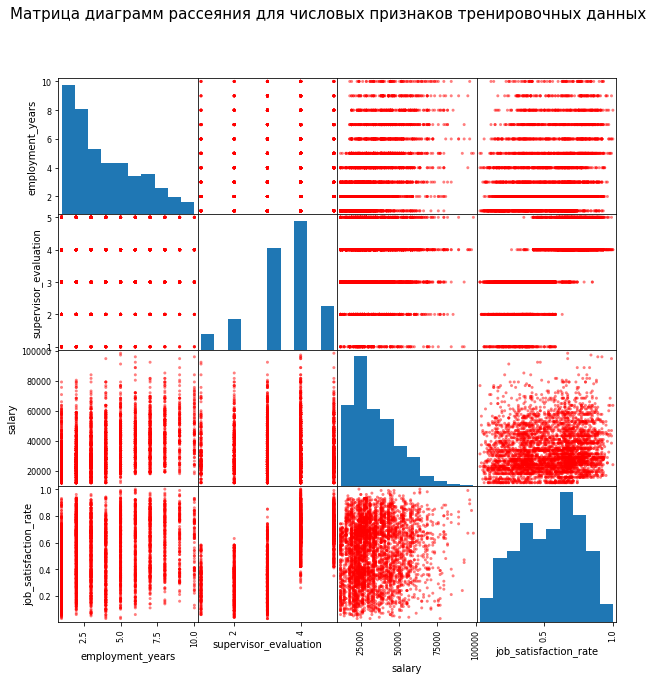

In [31]:
pd.plotting.scatter_matrix(train_job_satisfaction_rate.drop('id', axis=1), alpha=0.5, figsize=(10,10), color='r')
plt.suptitle('Матрица диаграмм рассеяния для числовых признаков тренировочных данных', fontsize=15)
plt.show()

**test_features**

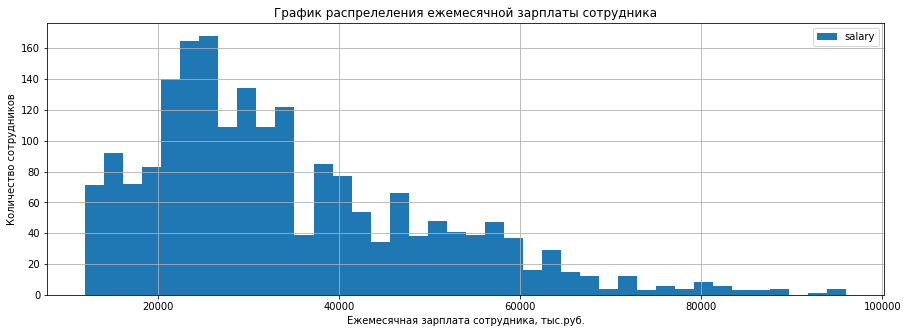

In [32]:
num_list_cont = ['salary']

ax = test_features[num_list_cont].plot(kind="hist",
                                       title=column,
                                       bins=40,
                                       grid=True,
                                      figsize=(15,5));
ax.set_xlabel('Ежемесячная зарплата сотрудника, тыс.руб.')
ax.set_ylabel('Количество сотрудников')
ax.set_title(f'График распрелеления ежемесячной зарплаты сотрудника')
plt.show()

In [33]:
num_list_dis = ['employment_years', 'supervisor_evaluation']

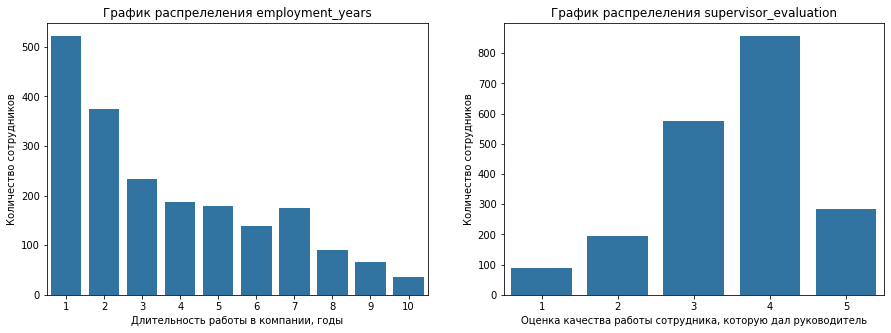

In [34]:
# Распределение значений численных признаков, проверка на выбросы:

xlabel_list_dis = ['Длительность работы в компании, годы',
                   'Оценка качества работы сотрудника, которую дал руководитель',
                   ]
               
fig = plt.figure(figsize=(15,5))
for i, col in enumerate(num_list_dis):
    fig.add_subplot(1, 2, i+1)
    ax = sns.countplot(test_features, x=col)
    ax.set_title(f'График распрелеления {num_list_dis[i]}')
    ax.set_xlabel(xlabel_list_dis[i])
    ax.set_ylabel('Количество сотрудников')
plt.show()

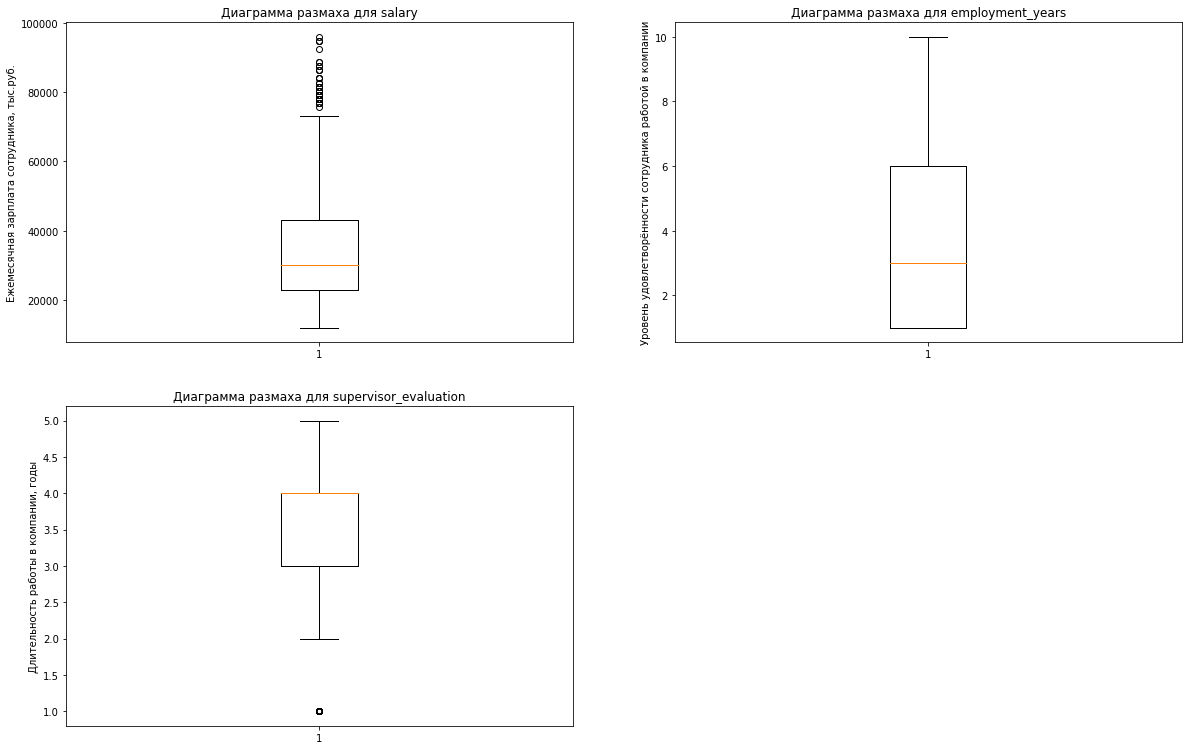

In [35]:
num_list_bx = num_list_cont + num_list_dis
x_label_num_list_bx = xlabel_list_cont + xlabel_list_dis
 
hist_num_boxplot(num_list_bx, x_label_num_list_bx, test_features)

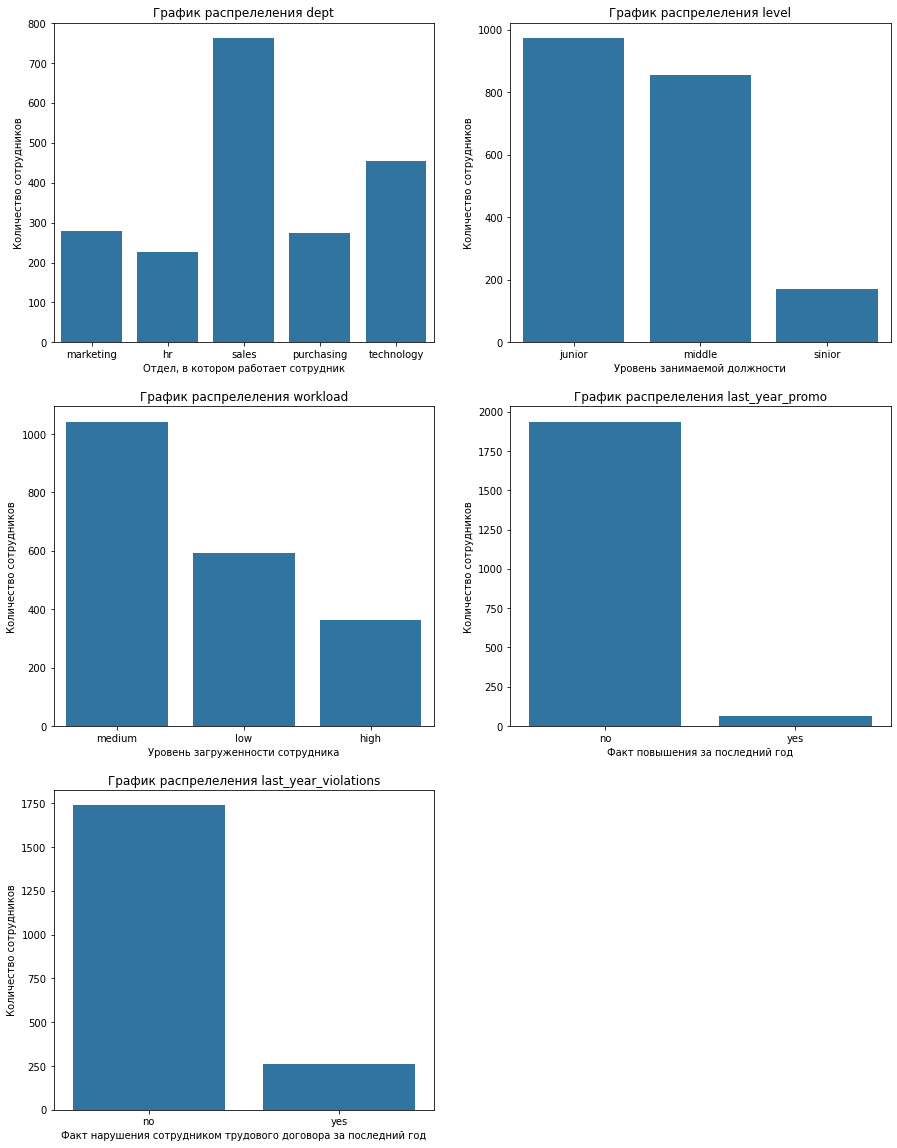

In [36]:
# Распределение значений категориальных признаков:

xlabel_cat_list = ['Отдел, в котором работает сотрудник',
                  'Уровень занимаемой должности',
                  'Уровень загруженности сотрудника',
                  'Факт повышения за последний год',
                  'Факт нарушения сотрудником трудового договора за последний год']

fig = plt.figure(figsize=(15,20))
for i, col in enumerate(cat_list):
    fig.add_subplot(3, 2, i+1)
    ax = sns.countplot(test_features, x=col)
    ax.set_title(f'График распрелеления {cat_list[i]}')
    ax.set_xlabel(xlabel_cat_list[i])
    ax.set_ylabel('Количество сотрудников')
plt.show()

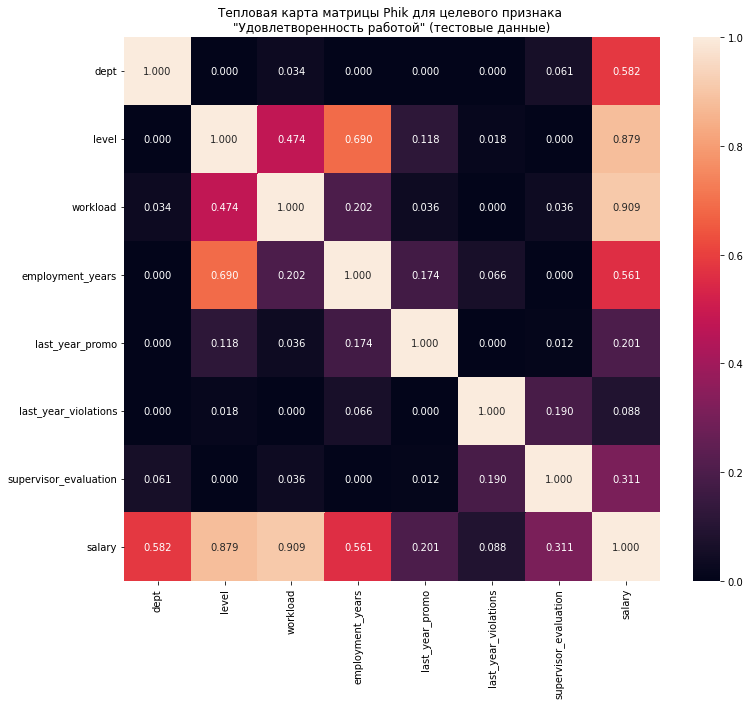

In [37]:
phik_matrix = phik.phik_matrix(test_features.drop('id', axis=1), interval_cols='job_satisfaction_rate');
plt.figure(figsize=(12,10));
sns.heatmap(phik_matrix, annot=True, fmt='.3f');
plt.title('Тепловая карта матрицы Phik для целевого признака \n"Удовлетворенность работой" (тестовые данные)', fontsize=12);

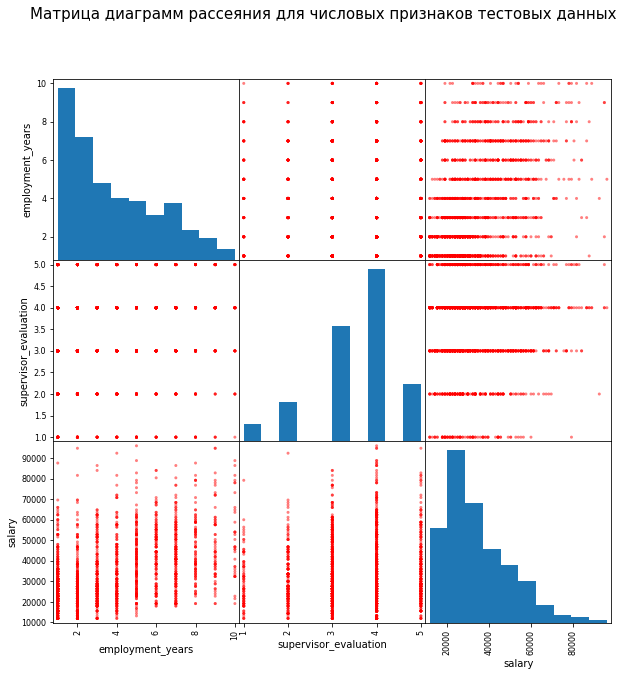

In [38]:
pd.plotting.scatter_matrix(test_features.drop('id', axis=1), alpha=0.5, figsize=(10,10), color='r')
plt.suptitle('Матрица диаграмм рассеяния для числовых признаков тестовых данных', fontsize=15)
plt.show()

**test_target_job_satisfaction_rate**

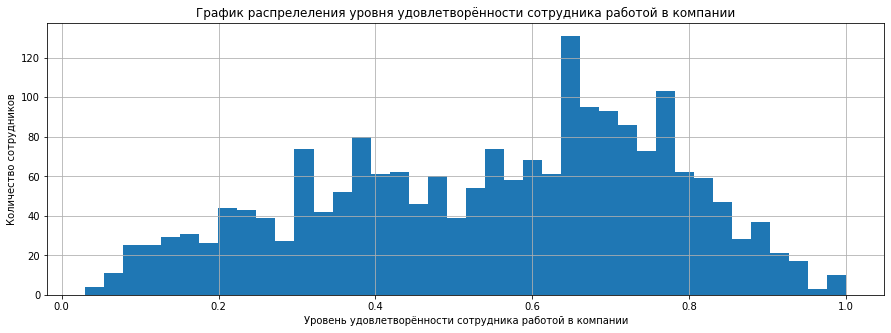

In [39]:
ax = test_target_job_satisfaction_rate['job_satisfaction_rate'].plot(kind="hist",
                                                                     title=column,
                                                                     bins=40,
                                                                     grid=True,
                                                                    figsize=(15,5)
                                                                    );
ax.set_xlabel('Уровень удовлетворённости сотрудника работой в компании')
ax.set_ylabel('Количество сотрудников')
ax.set_title(f'График распрелеления уровня удовлетворённости сотрудника работой в компании')
plt.show()

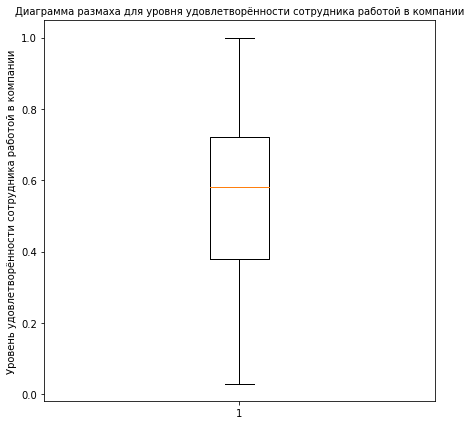

In [40]:
fig  = plt.figure(figsize=(7,7))
plt.boxplot(test_target_job_satisfaction_rate['job_satisfaction_rate']); 
plt.ylabel('Уровень удовлетворённости сотрудника работой в компании', fontsize=10);
plt.title(f'Диаграмма размаха для уровня удовлетворённости сотрудника работой в компании', fontsize=10)
plt.show()

**Вывод.**

- В результате предобработки полученных данных дубликаты не обнаружены.  
- Выявлены пропуски и пробелы в данных. Произведена замена пробелов ' ' на значения NaN. В дальнейшем произведем заполнение пропусков в пайплайне при обучении модели с использованием SimpleImputer в категориальных признаках на самое распростроненное значение.
- Аномальных (сильно выбивающихся из диапазона) значений не обнаружено.
- В результате корреляционного анализа мультиколлениарности между признаками не выявлено.

### Шаг 4. Подготовка данных

Обозначим особенности данных:

**Целевой признак — `job_satisfaction_rate`**.  

- Три признака: `dept`, `last_year_promo`, `last_year_violations` кодируем с помощью *OneHotEncoder*.  
- Два признака: `level`, `workload` кодируем с помощью *OrdinalEncoder*.
- Три численных признака: `employment_years`, `supervisor_evaluation`, `salary` масштабируем при помощи *StandardScaler*.
- Пропущенные \ отсутствующие значения замещаем на наиболе часто встречающееся с *SimpleImputer*

In [41]:
# Исключим `id` из данных для дальнейшей работы:

train_prepare_1 = train_job_satisfaction_rate.drop(['id'], axis=1)
print('Количество дубликатов:', train_prepare_1.duplicated().sum())

Количество дубликатов: 245


In [42]:
train_prepare_1 = train_prepare_1.drop_duplicates().reset_index(drop=True)

In [43]:
train_prepare_1.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,3755.000000,3755.000000,3755.000000,3755.000000
mean,3.817044,3.463648,34457.416778,0.532554
std,2.557142,1.026265,15050.643870,0.226393
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.350000
50%,3.000000,4.000000,31200.000000,0.550000
75%,6.000000,4.000000,44400.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


In [44]:
# Определим тренировочные массивы:

X_train_1 = train_prepare_1.drop(['job_satisfaction_rate'], axis=1)
y_train_1 = train_prepare_1['job_satisfaction_rate']

print(X_train_1.shape, y_train_1.shape)

(3755, 8) (3755,)


In [45]:
# Аналогично, для тестовых данных:

target_features_full = test_target_job_satisfaction_rate.merge(test_features, on='id')
target_features_full.head()

,id,job_satisfaction_rate,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,130604,0.74,technology,junior,medium,1,no,no,4,34800
1,825977,0.75,marketing,middle,high,7,no,no,5,58800
2,418490,0.60,purchasing,junior,low,1,no,no,4,19200
3,555320,0.72,technology,junior,medium,1,no,no,4,34800
4,826430,0.08,technology,junior,medium,1,no,yes,2,30000


In [46]:
test_prepare_1 = target_features_full.drop(['id'], axis=1)
print('Количество дубликатов:', target_features_full.duplicated().sum())

Количество дубликатов: 0


In [47]:
test_prepare_1.describe()

,job_satisfaction_rate,employment_years,supervisor_evaluation,salary
count,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.54878,3.666500,3.526500,34066.800000
std,0.22011,2.537222,0.996892,15398.436729
min,0.03000,1.000000,1.000000,12000.000000
25%,0.38000,1.000000,3.000000,22800.000000
50%,0.58000,3.000000,4.000000,30000.000000
75%,0.72000,6.000000,4.000000,43200.000000
max,1.00000,10.000000,5.000000,96000.000000


In [48]:
X_test_1 = test_prepare_1.drop(['job_satisfaction_rate'], axis=1)
y_test_1 = test_prepare_1['job_satisfaction_rate']

print(X_test_1.shape, y_test_1.shape)

(2000, 8) (2000,)


In [49]:
# Определим константы и признаки для дальнейшего использования в пайплайне:

RANDOM_STATE = 42

TEST_SIZE = 0.25

ohe_columns = [
    'last_year_violations', 
    'last_year_promo', 
    'dept'
]
ord_columns = [
    'level', 
    'workload' 
]
num_columns = [
    'salary', 
    'employment_years', 
    'supervisor_evaluation'
] 

In [50]:
# Составим пайплайн:

ohe_pipe = Pipeline(
        [
            (
                'simpleImputer_ohe', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ohe', 
                OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
            )
        ]
    ) 

ord_pipe = Pipeline(
        [
            (
                'simpleImputer_before_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ord',  
                OrdinalEncoder(
                    categories=[ 
                        ['junior', 'middle', 'sinior'],
                        ['low', 'medium', 'high'],
                    ], 
                    handle_unknown='use_encoded_value', unknown_value=np.nan
                )
            ),
            (
                'simpleImputer_after_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            )
        ]
    )    

data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, ohe_columns),
            ('ord', ord_pipe, ord_columns),
            ('num', StandardScaler(), num_columns)
        ], 
        remainder='passthrough'
    )

pipe_final = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', LinearRegression())
        ]
    )

### Шаг 5. Обучение моделей

Имея непрерывный количественный целевой признак, для обучения будем использовать модели регрессии:   
- модель линейной регрессии,  
- дерево решений (с перебором различных гиперпараметров).

In [51]:
param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'models__max_features': range(5, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [52]:
# Определим новую метрику — SMAPE. 
# Напишем функцию, которая принимает на вход массивы NumPy или объекты Series в pandas и возвращает значение метрики SMAPE. 
# Используем эту метрику при подборе гиперпараметров и оценке качества моделей. 

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
   
smape_scorer = make_scorer(score_func=smape, greater_is_better=False)

In [53]:
# Инициируем обучение посредством GridSearchCV.

grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=10,
    scoring=smape_scorer,
    n_jobs=-1,
)
grid_search.fit(X_train_1, y_train_1)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['last_year_violations',
                                                                          'last_year_promo',
                                                                          'dept']),
                                                                        ('ord',
                                                                         Pipeline...
             param_grid=[{'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(5, 15),
                          'models__max_features': range(5, 15),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [54]:
# Выберем лучшую модель и отобразим ее метрику.

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
#print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_*(-1))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                            

In [55]:
best_model = grid_search.best_estimator_

print(f'Метрика sMAPE лучшей модели по кросс-валидации на обучающих данных: {round(grid_search.best_score_*(-1),6)}')

Метрика sMAPE лучшей модели по кросс-валидации на обучающих данных: 15.501191


Лучшей моделью получилась модель `дерево решений` с максимальной глубиной - 13, максимальным числом признаков, по которым ищется лучшее разбиение в дереве - 10.

Далее проверим, как лучшая модель проявит себя на тестовой выборке, а также рассчитаем метрику SMAPE.

In [56]:
y_test_pred = grid_search.best_estimator_.predict
print(f'Метрика sMAPE лучшей модели на тестовой выборке: {round(smape(y_test_1, best_model.predict(X_test_1)),6)}')

Метрика sMAPE лучшей модели на тестовой выборке: 14.375291


Метрика на тестовой выборке получилась равной 14.38, что является лучшим результатом по сравнению со значением на тренировочной выборке (15.5).  

Можно сделать вывод, что модель работает хорошо.

Сохраним работу со всеми моделями, которые мы попробовали:

In [57]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.mean_test_score = cv_results.mean_test_score * -1
display(cv_results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_preprocessor__num,param_models__max_depth,param_models__max_features,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.069438,0.050215,0.020891,0.026486,LinearRegression(),StandardScaler(),NaN,NaN,"{'models': LinearRegression(), 'preprocessor__...",-24.150179,...,-25.166065,-24.528830,-27.455572,-25.888089,-24.489205,-24.824576,-22.622485,25.019179,1.223599,303
1,0.060208,0.034282,0.021085,0.026419,LinearRegression(),MinMaxScaler(),NaN,NaN,"{'models': LinearRegression(), 'preprocessor__...",-24.150179,...,-25.166065,-24.528830,-27.455572,-25.888089,-24.489205,-24.824576,-22.622485,25.019179,1.223599,302
2,0.056872,0.032149,0.020651,0.027372,LinearRegression(),passthrough,NaN,NaN,"{'models': LinearRegression(), 'preprocessor__...",-24.150179,...,-25.166065,-24.528830,-27.455572,-25.888089,-24.489205,-24.824576,-22.622485,25.019179,1.223599,301
3,0.033227,0.025678,0.008383,0.001804,DecisionTreeRegressor(random_state=42),StandardScaler(),5.0,5.0,{'models': DecisionTreeRegressor(random_state=...,-20.215830,...,-21.689911,-24.118869,-25.154990,-23.055822,-22.633866,-22.001364,-29.963626,23.505700,2.523034,298
4,0.019092,0.000603,0.007045,0.000251,DecisionTreeRegressor(random_state=42),MinMaxScaler(),5.0,5.0,{'models': DecisionTreeRegressor(random_state=...,-20.215830,...,-21.689911,-24.118869,-25.154990,-23.055822,-22.633866,-22.001364,-29.963626,23.505700,2.523034,298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.024629,0.000660,0.007380,0.000503,DecisionTreeRegressor(random_state=42),MinMaxScaler(),14.0,13.0,{'models': DecisionTreeRegressor(random_state=...,-15.515357,...,-15.957402,-16.213250,-16.263234,-15.812717,-16.155048,-15.937103,-15.236122,15.807243,0.408282,53
299,0.023160,0.000897,0.006954,0.001058,DecisionTreeRegressor(random_state=42),passthrough,14.0,13.0,{'models': DecisionTreeRegressor(random_state=...,-15.524338,...,-15.957402,-16.213250,-16.161647,-15.874786,-16.155048,-15.983713,-15.499003,15.818512,0.400449,59
300,0.024432,0.000355,0.007047,0.000165,DecisionTreeRegressor(random_state=42),StandardScaler(),14.0,14.0,{'models': DecisionTreeRegressor(random_state=...,-15.515357,...,-15.957402,-16.309132,-16.118054,-15.918554,-16.155048,-15.872552,-15.187757,15.764636,0.474887,46
301,0.024184,0.000379,0.007051,0.000262,DecisionTreeRegressor(random_state=42),MinMaxScaler(),14.0,14.0,{'models': DecisionTreeRegressor(random_state=...,-15.515357,...,-15.957402,-16.213250,-16.263234,-15.812717,-16.155048,-15.937103,-15.236122,15.807243,0.408282,53


### Шаг 6. Оформление выводов

Первая задача проекта выполнена - основе данных заказчика построена модель, предсказывающая уровень удовлетворённости сотрудника.

Проведено обучение моделей, и на основе метрики SMAPE выбрали лучшую - `дерево решений` с максимальной глубиной - 13, максимальным числом признаков, по которым ищется лучшее разбиение в дереве - 10. После проверки на тестовой выборке значение метрики осталось примерно на том же уровне (улучшилось). Критерий успеха (SMAPE ≤ 15 на тестовой выборке) соблюден.

Полагаю, `дерево решений` справилось лучше, чем `линейная регрессия`, из-за большей гибкости в настройке гиперпараметров.

Для поиска лучшей модели были предприняты следующие шаги:

проведено исследование полученных даных и признаков
в процессе поиска к данным применено 2 типа моделей классифкации
на основе метрики SMAPE была отобрана лучшая модель ('models', DecisionTreeRegressor(max_depth=13, max_features=11, random_state=100) c использованием пайплайна
метрика SMAPE лучшей модели на тренировочной выборке составила: 14.5585

## Задача 2: предсказание увольнения сотрудника из компании

### Шаг 1. Загрузка данных

In [58]:
try:
    train_quit = pd.read_csv('C:/Users/zephy/#Composite_project_2/train_quit.csv')
    test_target_quit = pd.read_csv('C:/Users/zephy/#Composite_project_2/test_target_quit.csv')
    
except:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
    test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
    
# test_features загружен ранее.

In [59]:
display(train_quit.head())

print('Размерность датафрейма train_job_satisfaction_rate:', train_quit.shape)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Размерность датафрейма train_job_satisfaction_rate: (4000, 10)


In [60]:
display(test_target_quit.head())

print('Размерность датафрейма train_job_satisfaction_rate:', test_target_quit.shape)

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Размерность датафрейма train_job_satisfaction_rate: (2000, 2)


Два новых датафрейма загружены и читаются корректно.

### Шаг 2. Предобработка данных

In [61]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [62]:
train_quit.duplicated().sum()

0

In [63]:
num_list = train_quit.drop('id', axis=1).select_dtypes(include=np.number).columns.tolist()
num_list

['employment_years', 'supervisor_evaluation', 'salary']

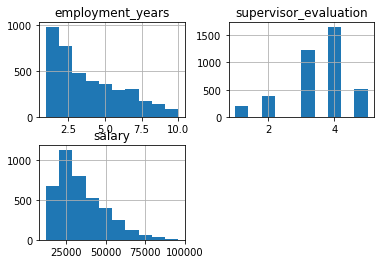

In [64]:
# Проверка на выбросы числовых начений:

train_quit.drop('id', axis=1).hist();

In [65]:
# Перечень категориальных признаков:

cat_list = train_quit.select_dtypes(exclude=np.number).columns.tolist()
cat_list

['dept',
 'level',
 'workload',
 'last_year_promo',
 'last_year_violations',
 'quit']

In [66]:
# Проверка на неявные дубликаты:

for item in cat_list:
    print('\n',train_quit[item].unique())


 ['sales' 'purchasing' 'marketing' 'technology' 'hr']

 ['middle' 'junior' 'sinior']

 ['high' 'medium' 'low']

 ['no' 'yes']

 ['no' 'yes']

 ['no' 'yes']


In [67]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [68]:
test_target_quit.duplicated().sum()

0

In [69]:
test_target_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

### Шаг 3. Исследовательский анализ данных

**train_quit**

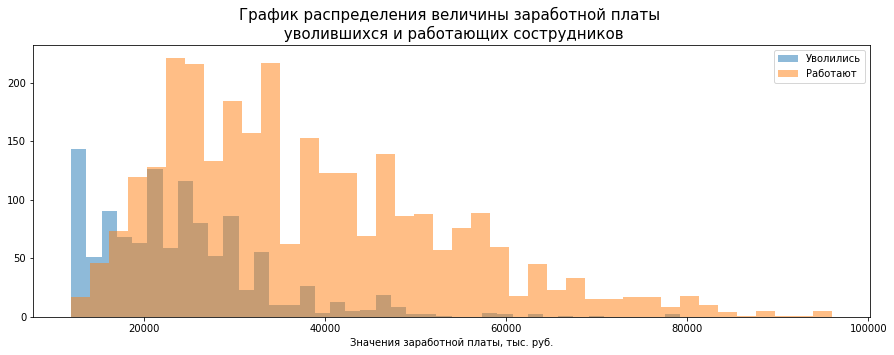

In [70]:
# Сравним среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

plt.figure(figsize=(15, 5))
ax = plt.hist(train_quit.query('quit == "yes"')['salary'], bins=40, alpha=0.5);
ax = plt.hist(train_quit.query('quit == "no"')['salary'], bins=40, alpha=0.5);
plt.xlabel('Значения заработной платы, тыс. руб.')
plt.title('График распределения величины заработной платы \n уволившихся и работающих сострудников', fontsize=15);
plt.legend(['Уволились', 'Работают'])
plt.show()

In [71]:
cat_list = train_quit.drop('quit', axis=1).select_dtypes(exclude=np.number).columns.tolist()
cat_list = cat_list + ['employment_years']
cat_list

['dept',
 'level',
 'workload',
 'last_year_promo',
 'last_year_violations',
 'employment_years']

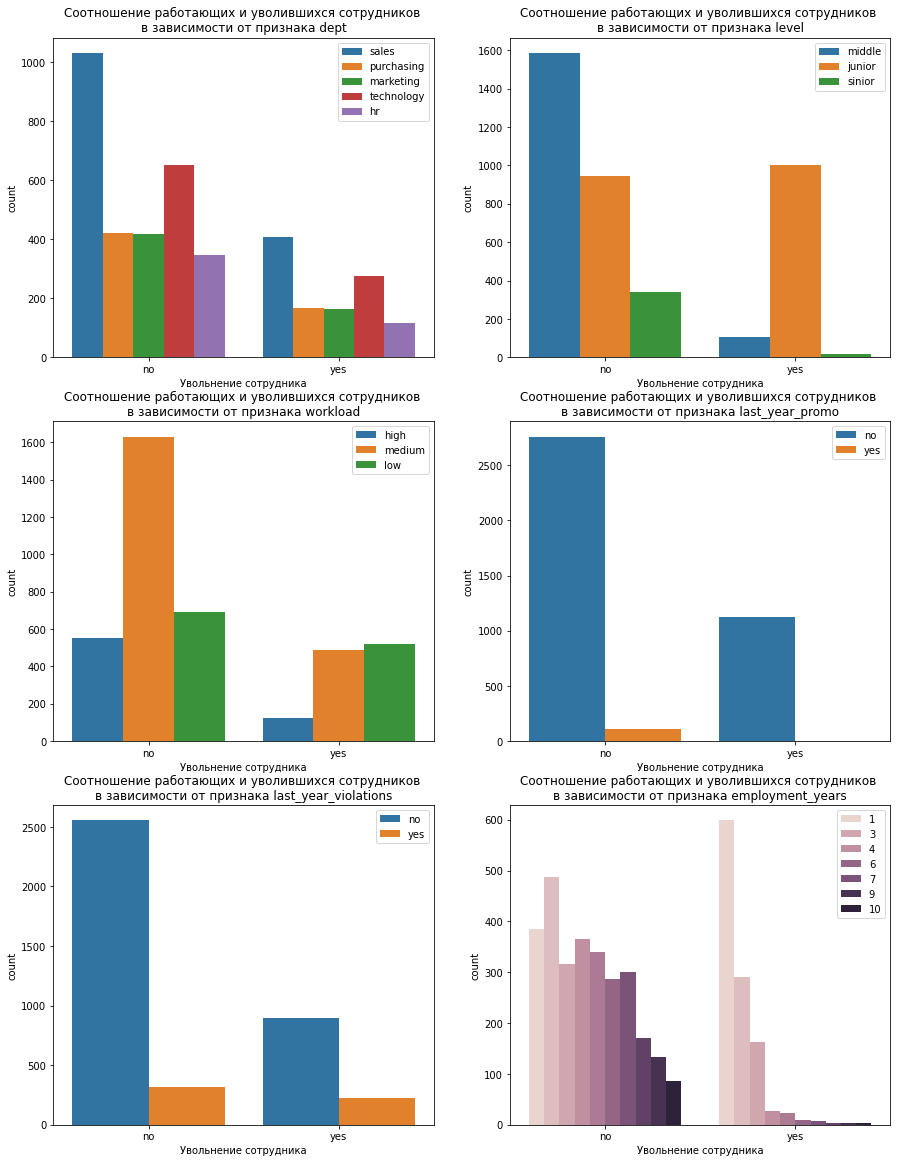

In [72]:
fig = plt.figure(figsize=(15,20))

for i, column in enumerate(cat_list):
    fig.add_subplot(3, 2, i + 1);
    ax = sns.countplot(x = 'quit', hue = column, data = train_quit);
    ax.set_title(f'Соотношение работающих и уволившихся сотрудников \nв зависимости от признака {column}')
    ax.set_xlabel('Увольнение сотрудника')
    ax.legend(loc='upper right')

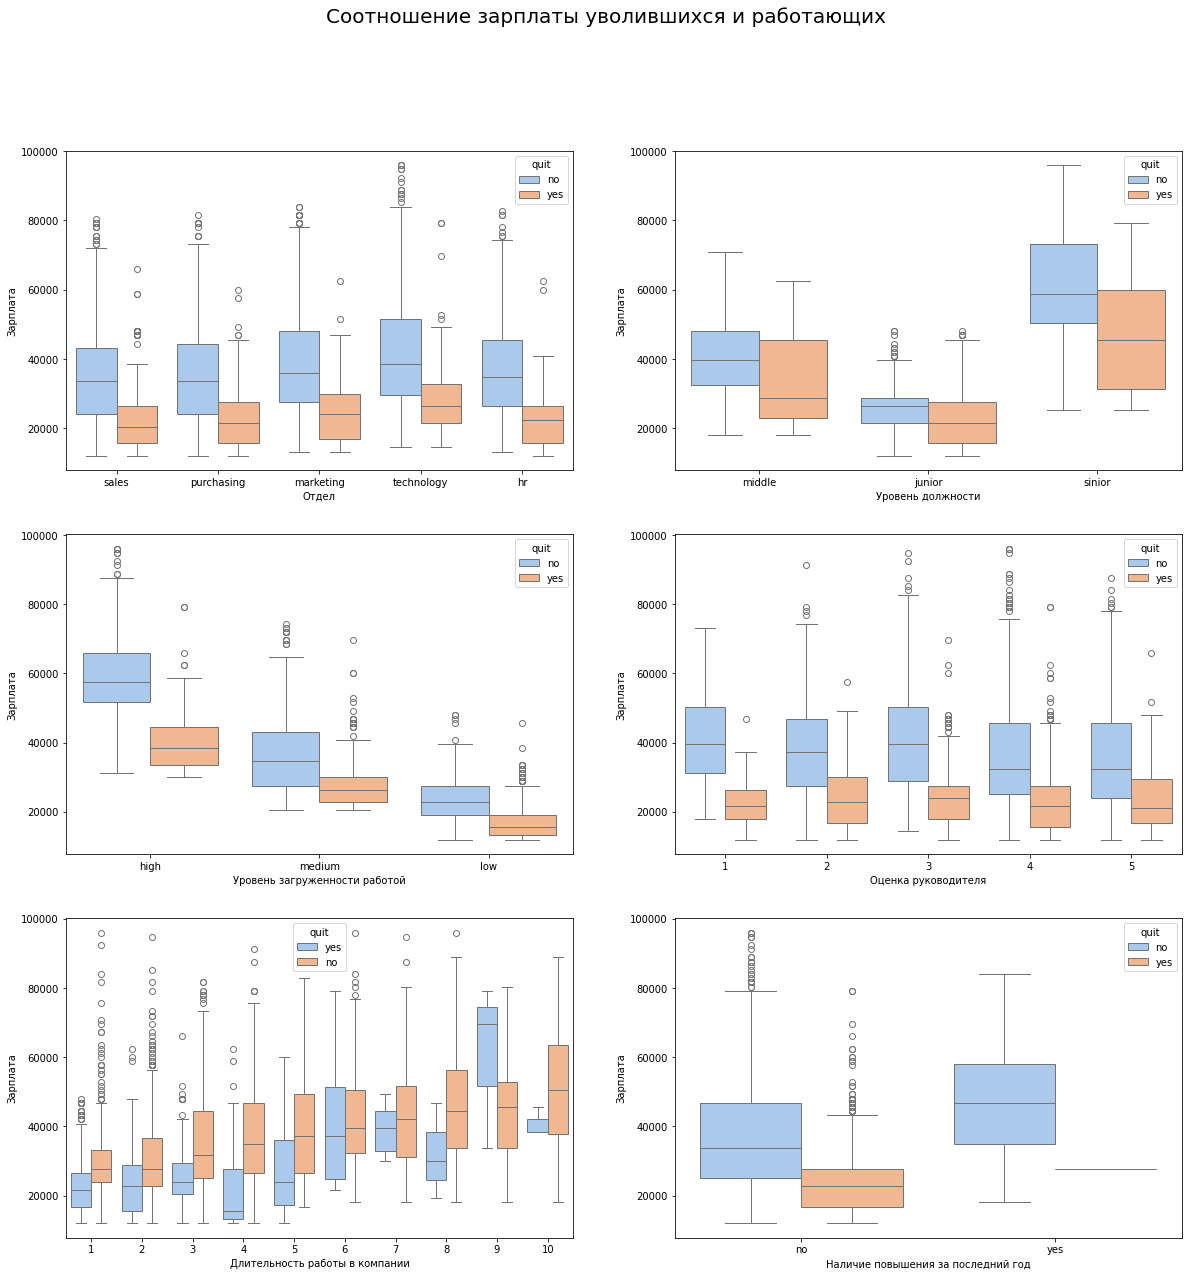

In [73]:
fig, axes = plt.subplots(3, 2, figsize=(20,20))
plt.suptitle('Соотношение зарплаты уволившихся и работающих', fontsize=20)
sns.boxplot(x='dept', y='salary', hue='quit', palette='pastel',
            data=train_quit, ax=axes[0,0]).set(xlabel='Отдел', ylabel='Зарплата');
sns.boxplot(x='level', y='salary', hue='quit', palette='pastel',
            data=train_quit, ax=axes[0,1]).set(xlabel='Уровень должности', ylabel='Зарплата');
sns.boxplot(x='workload', y='salary', hue='quit', 
            palette='pastel', data=train_quit, ax=axes[1,0]).set(xlabel='Уровень загруженности работой', ylabel='Зарплата');
sns.boxplot(x='supervisor_evaluation', y='salary', hue='quit', 
            palette='pastel', data=train_quit, ax=axes[1,1]).set(xlabel='Оценка руководителя', ylabel='Зарплата');
sns.boxplot(x='employment_years', y='salary', hue='quit', palette='pastel',
            data=train_quit, ax=axes[2,0]).set(xlabel='Длительность работы в компании', ylabel='Зарплата');
sns.boxplot(x='last_year_promo', y='salary', hue='quit', palette='pastel',
            data=train_quit, ax=axes[2,1]).set(xlabel='Наличие повышения за последний год', ylabel='Зарплата');

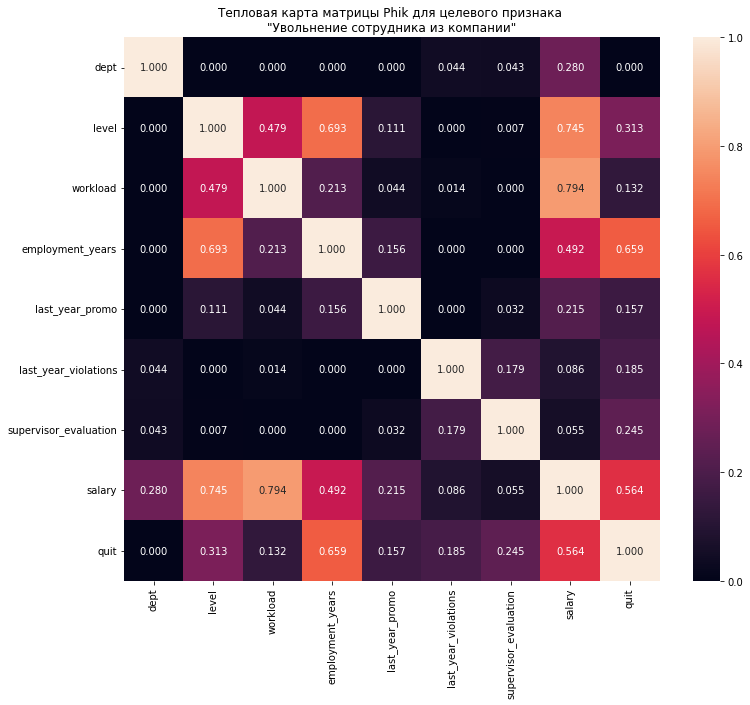

In [74]:
phik_matrix = phik.phik_matrix(train_quit.drop('id', axis=1), interval_cols=['salary', 'job_satisfaction_rate']);
plt.figure(figsize=(12,10));
sns.heatmap(phik_matrix, annot=True, fmt='.3f');
plt.title('Тепловая карта матрицы Phik для целевого признака \n"Увольнение сотрудника из компании"', fontsize=12);

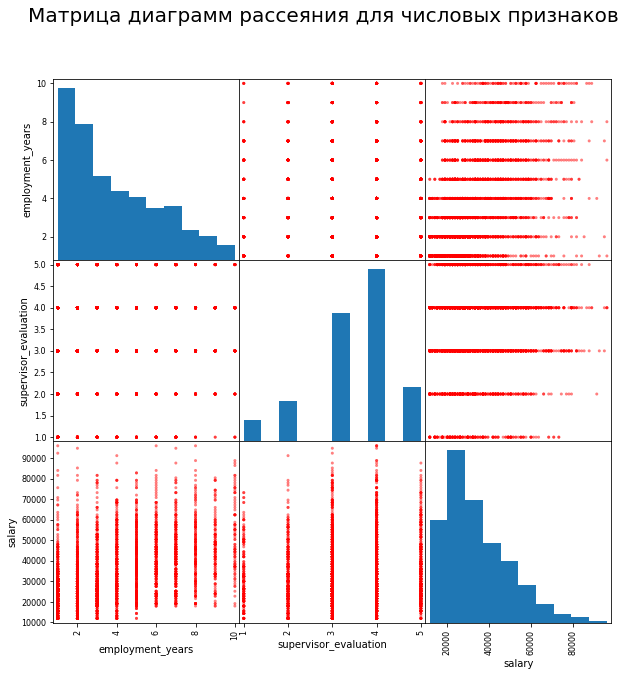

In [75]:
pd.plotting.scatter_matrix(train_quit.drop('id', axis=1), alpha=0.5, figsize=(10,10), color='r')
plt.suptitle('Матрица диаграмм рассеяния для числовых признаков', fontsize=20)
plt.show()

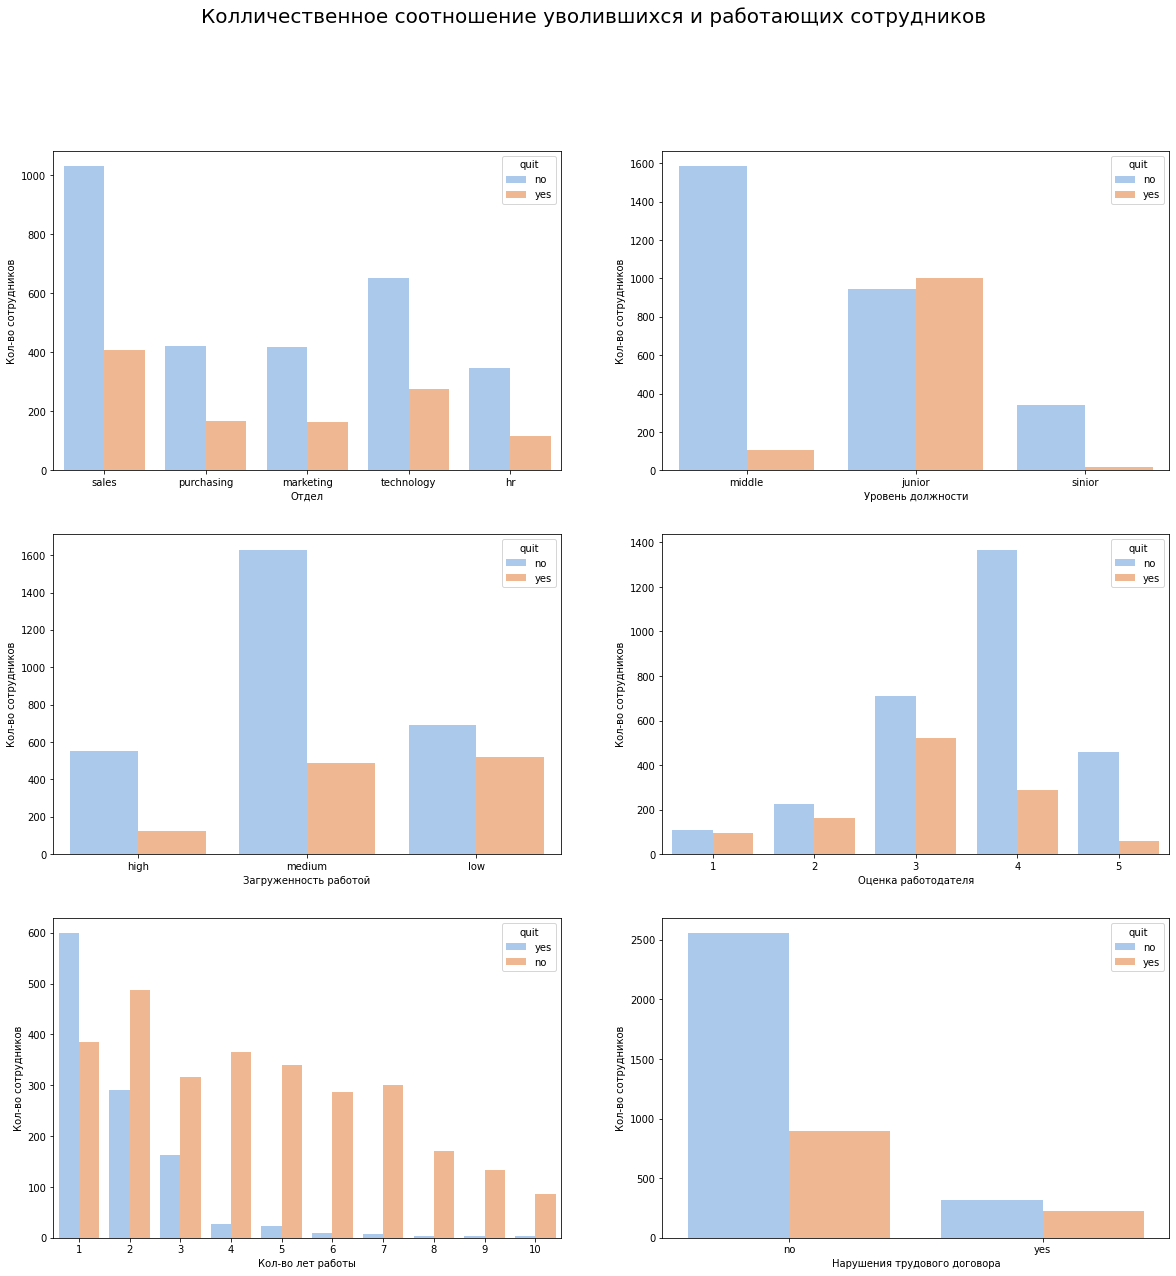

In [76]:
fig, axes = plt.subplots(3, 2, figsize=(20,20))
plt.suptitle('Колличественное соотношение уволившихся и работающих сотрудников', fontsize=20)
sns.countplot(x ='dept', hue = 'quit', data = train_quit,
              palette = "pastel", ax=axes[0,0]).set(xlabel='Отдел', ylabel='Кол-во сотрудников');
sns.countplot(x ='level', hue = 'quit', data = train_quit,
              palette = "pastel", ax=axes[0,1]).set(xlabel='Уровень должности', ylabel='Кол-во сотрудников');
sns.countplot(x ='workload', hue = 'quit', data = train_quit,
              palette = "pastel", ax=axes[1,0]).set(xlabel='Загруженность работой', ylabel='Кол-во сотрудников');
sns.countplot(x ='supervisor_evaluation', hue = 'quit', data = train_quit,
              palette = "pastel", ax=axes[1,1]).set(xlabel='Оценка работодателя', ylabel='Кол-во сотрудников');
sns.countplot(x ='employment_years', hue = 'quit', data = train_quit,
              palette = "pastel", ax=axes[2,0]).set(xlabel='Кол-во лет работы', ylabel='Кол-во сотрудников');
sns.countplot(x ='last_year_violations', hue = 'quit', data = train_quit,
              palette = "pastel", ax=axes[2,1]).set(xlabel='Нарушения трудового договора', ylabel='Кол-во сотрудников');

In [77]:
# Получим численные значения уволившихся, найдём их долю от общего сисла сотрудников:

for i in cat_list:
    print(f'\nПоказатели текучести кадров в компании в зависимости от {i}:')
    quit_pivot=train_quit.pivot_table(index='quit', values='id', columns=i, aggfunc='count')
    quit_pivot_T=quit_pivot.T
    quit_pivot_T['quit_part']=round(quit_pivot_T['yes']/(quit_pivot_T['yes'] + quit_pivot_T['no']), 3)
    display(quit_pivot_T)


Показатели текучести кадров в компании в зависимости от dept:


quit,no,yes,quit_part
dept,,,
hr,348,116,0.250
marketing,419,163,0.280
purchasing,422,166,0.282
sales,1031,407,0.283
technology,652,276,0.297



Показатели текучести кадров в компании в зависимости от level:


quit,no,yes,quit_part
level,,,
junior,946,1003,0.515
middle,1586,108,0.064
sinior,340,17,0.048



Показатели текучести кадров в компании в зависимости от workload:


quit,no,yes,quit_part
workload,,,
high,553,121,0.18
low,689,519,0.43
medium,1630,488,0.23



Показатели текучести кадров в компании в зависимости от last_year_promo:


quit,no,yes,quit_part
last_year_promo,,,
no,2760,1127,0.290
yes,112,1,0.009



Показатели текучести кадров в компании в зависимости от last_year_violations:


quit,no,yes,quit_part
last_year_violations,,,
no,2555,900,0.260
yes,317,228,0.418



Показатели текучести кадров в компании в зависимости от employment_years:


quit,no,yes,quit_part
employment_years,,,
1,386,599,0.608
2,487,290,0.373
3,316,163,0.340
4,366,27,0.069
5,339,23,0.064
6,286,10,0.034
7,301,7,0.023
8,171,3,0.017
9,133,3,0.022


Выводы:

- Отдел на кол-во увольнений не влияет (доля уволенных: 0.250-0.297).
- Чаще всего увольняются малоквалифицированные работники (доля уволенных: 0.515).
- Доля увольнений малозанятых сотрудников свыше 40%. 
- Получив повышение, сотрудник с вероятностью выше 99% останется в компании.
- 2 из 5 сотрудников увольняются после нарушения тр. договора.
- Наибольшая текучесть кадров наблюдается среди сотрудников, работающих в компании недавно. Отработавшие более 3х лет уходят редко.
- Размер зарплаты имеет немалое значение: склонны к уволнению работники (со стажем свыше 3 лет), которые имеют одинаковые уровни должности / занятости, при этом получают меньше, нежели коллеги.

Попробуем составить **портрет «уволившегося сотрудника»**:

Вероятнее всего, это джун, который недавно пришел в компанию (менее 2 лет) и слабо озадачен начальником. Возможно, такой работник нарушает дисциплину или условия договора, не ожидает повышения в должности. Все это отражается на уровне зарплаты и, в конечном счете, влияет на решение об увольнении.

### Шаг 4. Добавление нового входного признака

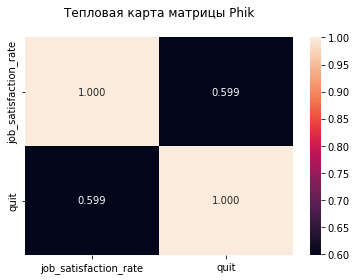

In [78]:
# Измерим взаимосвязь уровня удовлетворенность работой с решением об увольнении:

satisfaction_quit_corr = test_target_job_satisfaction_rate.merge(test_target_quit, on='id')
phik_mtx = phik.phik_matrix(satisfaction_quit_corr.drop('id', axis=1), interval_cols='job_satisfaction_rate')
sns.heatmap(phik_mtx, annot=True, fmt='.3f');
plt.title('Тепловая карта матрицы Phik\n');

Добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

Добавим признак удовлетворенности работой в наши выборки: тестовую и тренировочную. Для этого воспользуемся нашей лучшей моделью из первой задачи. Получим предсказания удовлетворенности и добавим в виде дополнительного столбца в тестовую и тренировочную выборки.

In [79]:
train_quit['job_satisfaction_rate_predict'] = best_model.predict(train_quit)
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_predict
0,723290,sales,middle,high,2,no,no,4,54000,no,0.646765
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.853529
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.364091
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [80]:
train_quit.shape

(4000, 11)

Быть может, размер зарплаты существенно влияет на удовлетворенность работой?

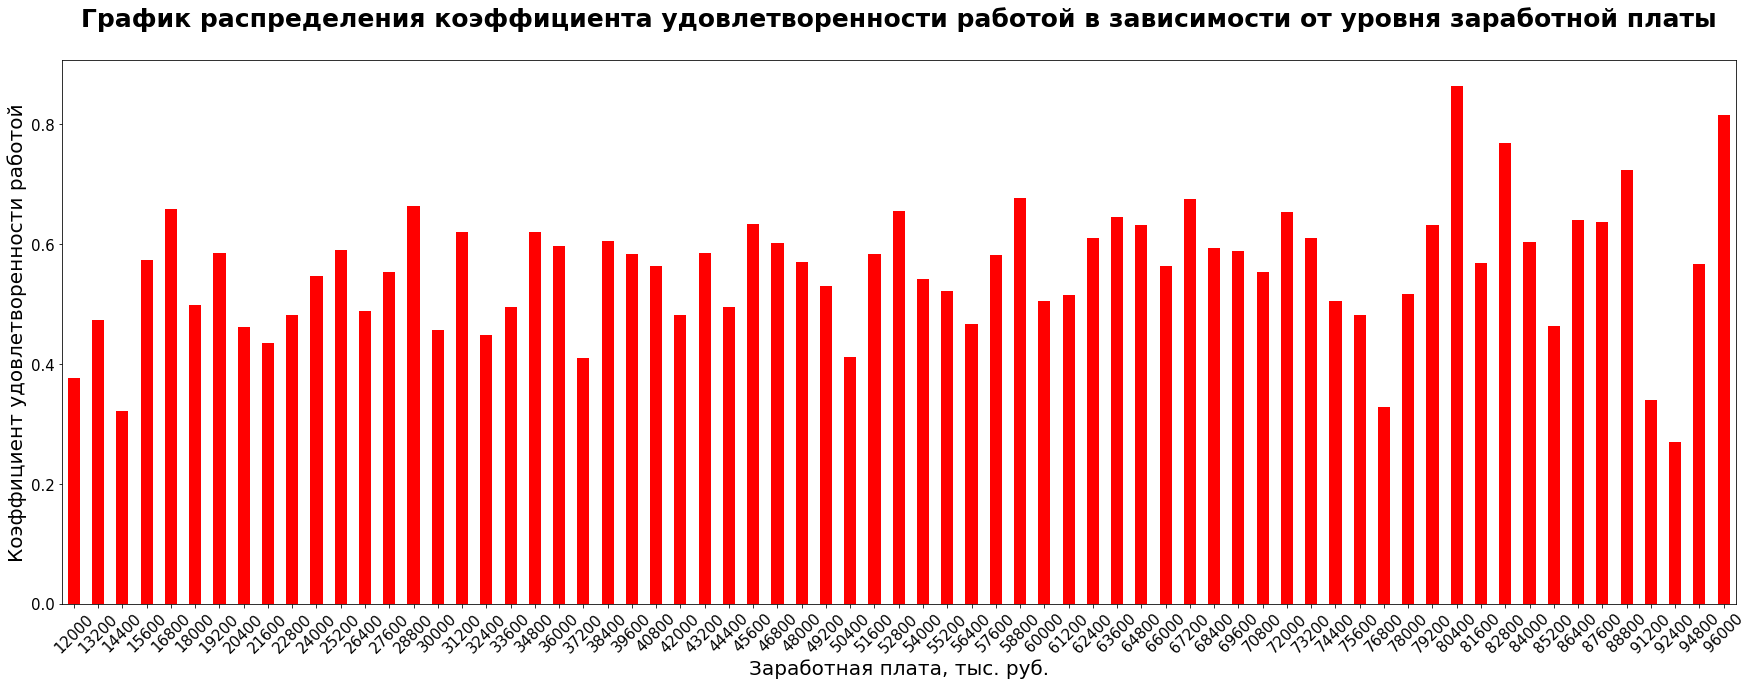

In [81]:
satisfaction_salary = train_quit.pivot_table(index = 'salary', values = 'job_satisfaction_rate_predict', aggfunc='mean')
satisfaction_salary['job_satisfaction_rate_predict'].plot(kind='bar', figsize=(30, 10), fontsize=15, color='red', rot=45);
plt.title('График распределения коэффициента удовлетворенности работой в зависимости от уровня заработной платы\n',
          fontsize=25, fontweight="bold");
plt.xlabel('Заработная плата, тыс. руб.', fontsize=20);
plt.ylabel('Коэффициент удовлетворенности работой', fontsize=20);

In [82]:
train_quit['salary'].corr(train_quit['job_satisfaction_rate_predict'])

0.12151861771141148

Зависимость незначительная.

**Вывод:**

Мы добавили новый входной признак в тестовую и тренировочную выборки и готовы к подготовке данных для обучения моделей.

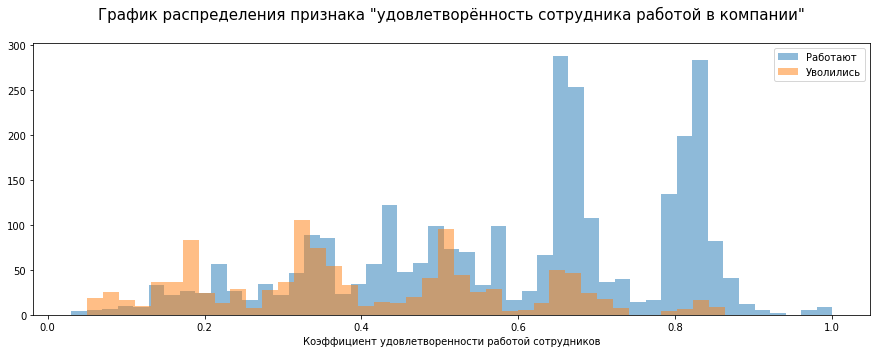

In [83]:
# Рассмотрим гистограмму распределения признака job_satisfaction_rate (колличественная):

plt.figure(figsize=(15,5))

ax = plt.hist(train_quit.query('quit == "no"')['job_satisfaction_rate_predict'], bins=49, alpha=0.5);
ax = plt.hist(train_quit.query('quit == "yes"')['job_satisfaction_rate_predict'], bins=40, alpha=0.5);
plt.xlabel('Коэффициент удовлетворенности работой сотрудников')
plt.title('График распределения признака "удовлетворённость сотрудника работой в компании"\n', fontsize=15);
plt.legend(['Работают', 'Уволились'])
plt.show()

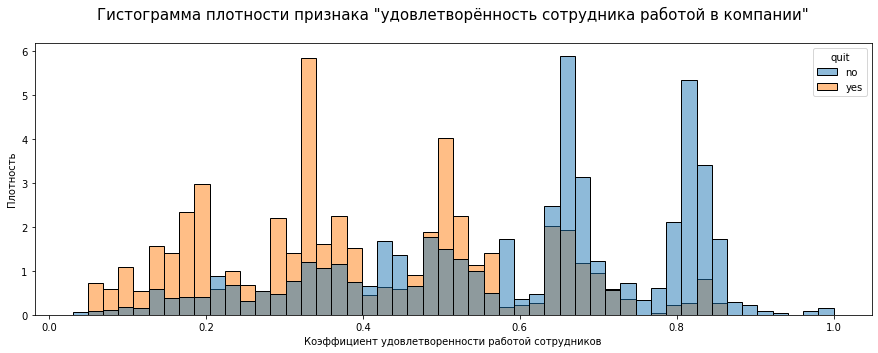

In [84]:
# Рассмотрим гистограмму распределения признака job_satisfaction_rate (плотности):
# Поскольку количество наблюдений в группах разное, установим для параметра common_norm значение False,
# чтобы нормализовать каждую гистограмму отдельно.

plt.figure(figsize=(15,5))
sns.histplot(data=train_quit, x='job_satisfaction_rate_predict', hue='quit', bins=50, stat='density', common_norm=False);
plt.title('Гистограмма плотности признака "удовлетворённость сотрудника работой в компании"\n', fontsize=15);
plt.xlabel('Коэффициент удовлетворенности работой сотрудников');
plt.ylabel('Плотность');
plt.show()

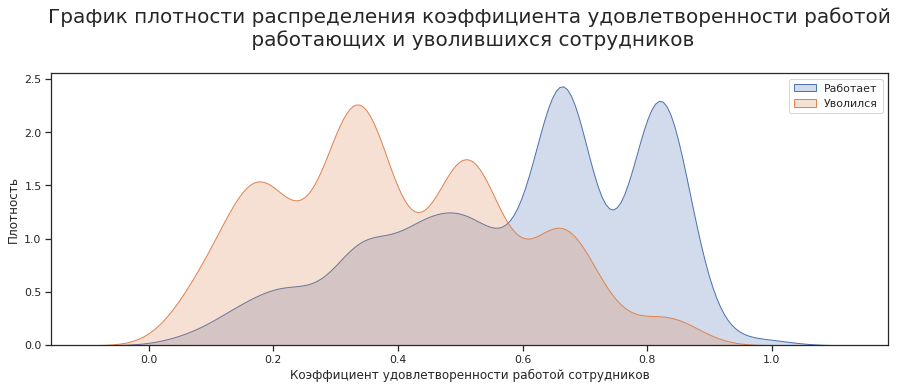

In [85]:
plt.figure(figsize=(15,5))
sns.set_theme(style="ticks");
sns.kdeplot(train_quit.query('quit == "no"')['job_satisfaction_rate_predict'], fill=True);
sns.kdeplot(train_quit.query('quit == "yes"')['job_satisfaction_rate_predict'], fill=True);
plt.title('График плотности распределения коэффициента удовлетворенности работой\n работающих и уволившихся сотрудников\n',
          fontsize=20)
plt.xlabel('Коэффициент удовлетворенности работой сотрудников')
plt.ylabel('Плотность')
plt.legend(['Работает', 'Уволился'])
plt.show()

/tmp/ipykernel_112/2750541973.py:8: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  plt.pie(x=[quit_no_mean, quit_yes_mean],


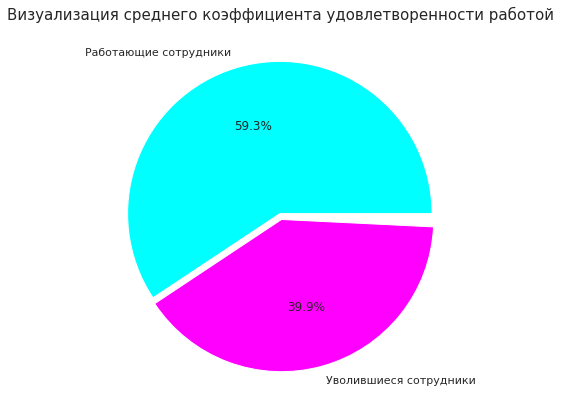

In [86]:
quit_no_mean = train_quit['job_satisfaction_rate_predict'][train_quit['quit'] == 'no'].mean()
quit_yes_mean = train_quit['job_satisfaction_rate_predict'][train_quit['quit'] == 'yes'].mean()

plt.figure(figsize=(7,7))

labels = ['Работающие сотрудники', 'Уволившиеся сотрудники']

plt.pie(x=[quit_no_mean, quit_yes_mean],
        labels = labels, explode = [0.02, 0.02],
        colors = ["cyan", "magenta"],
        autopct='%.1f%%'
       );
plt.title('Визуализация среднего коэффициента удовлетворенности работой', fontsize=15)
plt.show() 

Средний коэффициент удовлетворенности для работающих в компании сотрудников составляет 59.8, для уволившихся сотрудников - 40.2.

### Шаг 5. Подготовка данных

Обозначим особенности данных:

**Целевой признак — `quit`**.

- Три признака: `dept`, `last_year_promo`, `last_year_violations` кодируем с помощью *OneHotEncoder*.  
- Два признака: `level`, `workload` кодируем с помощью *OrdinalEncoder*.  
- Три численных признака: `employment_years`, `supervisor_evaluation`, `salary` масштабируем при помощи *StandardScaler*.  
- Пропущенные \ отсутствующие значения замещаем на наиболе часто встречающееся с *SimpleImputer*

In [87]:
train_prepare_2 = train_quit.drop(['id'], axis=1)

In [88]:
train_prepare_2.duplicated().sum()

1413

In [89]:
train_prepare_2 = train_prepare_2.drop_duplicates().reset_index(drop=True)
display(train_prepare_2.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_predict
0,sales,middle,high,2,no,no,4,54000,no,0.646765
1,sales,junior,medium,2,no,no,4,27600,no,0.853529
2,purchasing,middle,medium,5,no,no,1,37200,no,0.364091
3,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
4,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [90]:
X_train_2 = train_prepare_2.drop(['quit'], axis=1)
y_train_2 = train_prepare_2['quit']

print(X_train_2.shape)
print(y_train_2.shape)

(2587, 9)
(2587,)


In [91]:
test_features['job_satisfaction_rate_predict'] = best_model.predict(test_features)

In [92]:
target_features_full = test_features.merge(test_target_quit, on='id')

In [93]:
test_prepare_2 = target_features_full.drop(['id'], axis=1)

In [94]:
X_test_2 = test_prepare_2.drop(['quit'], axis=1)
y_test_2 = test_prepare_2['quit']

print(X_test_2.shape)
print(y_test_2.shape)

(2000, 9)
(2000,)


Кодируем целевой категориальный признак:

In [95]:
le = LabelEncoder()
y_train_2 = le.fit_transform(y_train_2)
y_test_2 = le.transform(y_test_2)

In [96]:
ohe_columns = [
    'last_year_violations', 
    'last_year_promo', 
    'dept'
]
ord_columns = [
    'level', 
    'workload' 
]
num_columns = [
    'salary',
    'employment_years',
    'supervisor_evaluation',
    'job_satisfaction_rate_predict'
] 

In [97]:
ohe_pipe = Pipeline(
        [
            (
                'simpleImputer_ohe', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ohe', 
                OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
            )
        ]
    ) 

ord_pipe = Pipeline(
        [
            (
                'simpleImputer_before_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ord',  
                OrdinalEncoder(
                    categories=[ 
                        ['junior', 'middle', 'sinior'],
                        ['low', 'medium', 'high'],
                    ], 
                    handle_unknown='use_encoded_value', unknown_value=np.nan
                )
            ),
            (
                'simpleImputer_after_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            )
        ]
    )    

data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, ohe_columns),
            ('ord', ord_pipe, ord_columns),
            ('num', StandardScaler(), num_columns)
        ], 
        remainder='passthrough'
    )

pipe_final = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', LinearRegression())
        ]
    )

**Вывод:**

На данном этапе произведена подготовка данных с использованием пайплайна:
- кодирование,
- масштабирование,
- обработка пропусков.

Можно приступать к обучению моделей.

### Шаг 6. Обучение модели

Целевой признак один - Увольнение. Вариантов всего 2 - да (1) или нет (0). Т.о., нам предстоит задача бинарной классификации.   

Будем использовать следующие модели:

- Дерево решений (`DecisionTreeClassifier()`),
- Метод k ближайших соседей (`KNeighborsClassifier()`), 
- Метод случайного леса (`RandomForestClassifier()`),
- Логистическая регрессия (`LogisticRegression()`),
- Метод опорных векторов (`SVC()`).

Зададим гиперпараметры для обозначенных выше моделей:

In [98]:
param_grid = [
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    
     {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            kernel = 'rbf'
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    }
]

В целях экономии ресурсов и для ускорения работы алгоритма запустим обучение используя метод RandomizedSearchCV.  
Для оценки качества моделей будем использовать независимую от порога классификации метрику ROC_AUC, как самую универсальную.

In [99]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train_2, y_train_2)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['last_year_violations',
                                                                                'last_year_promo',
                                                                                'dept']),
                                                                              ('ord',
                                                                               Pip...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [SVC(random_state=42)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

In [100]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                            

Лучшей моделью оказалось дерево решений с максимальной глубиной 4 и максимальным числом признаков, по которым ищется лучшее разбиение в дереве - 12.

Теперь проверим, как лучшая модель проявит себя на тестовой выборке. И рассчитаем метрику ROC_AUC.

In [101]:
y_test_proba = randomized_search.predict_proba(X_test_2)[:,1]

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_2, y_test_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.9147534769552936


In [102]:
pd.DataFrame(randomized_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.020396,0.001502,0.008419,0.000183,StandardScaler(),10,7,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",0.885431,0.876787,0.868667,0.867800,0.901155,0.879968,0.012366,7
1,0.020418,0.002225,0.008611,0.000387,StandardScaler(),9,10,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",0.807436,0.835259,0.821441,0.801273,0.820880,0.817258,0.011888,10
2,0.017953,0.000437,0.007167,0.000216,passthrough,16,13,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",0.727754,0.788379,0.805452,0.782646,0.862770,0.793400,0.043377,15
3,0.017858,0.000483,0.008025,0.000219,MinMaxScaler(),12,4,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",0.906137,0.897781,0.891093,0.904754,0.918078,0.903569,0.009029,1
4,0.017727,0.000843,0.007428,0.000739,passthrough,19,11,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",0.775092,0.789526,0.818099,0.796513,0.854989,0.806844,0.027783,12
5,0.017545,0.000435,0.007419,0.000093,passthrough,15,8,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",0.851704,0.868143,0.842285,0.861454,0.905937,0.865905,0.021849,9
6,0.020195,0.000328,0.008177,0.000165,StandardScaler(),11,11,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",0.780882,0.754738,0.826207,0.788701,0.855306,0.801167,0.035442,14
7,0.017910,0.000469,0.007108,0.000202,passthrough,16,12,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",0.767134,0.801368,0.819741,0.788560,0.853068,0.805974,0.029122,13
8,0.018057,0.000408,0.008154,0.000187,StandardScaler(),7,6,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",0.887590,0.902699,0.869903,0.879268,0.894420,0.886776,0.011434,5
9,0.018793,0.001475,0.008282,0.000228,StandardScaler(),18,5,DecisionTreeClassifier(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",0.906275,0.900444,0.878584,0.900486,0.907120,0.898582,0.010383,2


Критерий успеха, где ROC-AUC ≥ 0.91 на тестовой выборке, соблюден.

### Шаг 7. Выводы

По завершении работы над второй задачей мы обучили модель предсказывать, уволится сотрудник из компании или нет.  
Лучшей моделью для этой задачи оказалось `дерево решений`: точность предсказаний - более 91%.   
Вероятно, `дерево решений` справилось лучше других моделей из-за большей гибкости в настройке гиперпараметров.

## Общий вывод

Для поиска лучшей модели, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика (**Задача 1**), предприняты следующие шаги:

- проведено исследование полученных данных и признаков,
- построена модель с метрикой `SMAPE`, значение которой не приевысило `15` на тестовой выборке,
- в процессе поиска к данным применено два типа моделей классификации,
- на основе метрики `SMAPE` c использованием пайплайна была отобрана лучшая модель с параметрами: DecisionTreeRegressor(`max_depth=13`, `max_features=10`, `random_state=42`),

Метрика `SMAPE` лучшей модели на тестовой выборке составила: `14.37529`

Для поиска лучшей модели, которая сможет предсказать на основе данных заказчика, что сотрудник уволится из компании (**Задача 2**), предприняты следующие шаги:

- проведено исследование полученных данных и признаков,
- построена модель с метрикой ROC-AUC не менее `0.91`,
- на основе метрики `ROC-AUC` c использованием пайплайна была отобрана лучшая модель с параметрами: 
DecisionTreeClassifier(`max_depth=4`, `max_features=12`, `random_state=42`)

Метрика `ROC-AUC` на тестовой выборке составила: `0.9147535`

**К предложениям для бизнеса можно отнести:**
- необходимость следить за удовлетворенностью работой своих сотрудников, чтобы те реже увольнялись,
- ускорить систему повышения в должности с junior в разряд middle,
- следить за загруженностью работой сотрудников, активнее вовлекать их в рабочий процесс,
- не забывать повышать зарплату, поощрять активность / инициативу.